## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.metrics import log_loss, f1_score, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import lightgbm as lgb
from xgboost import XGBRegressor
import optuna

## Set file paths for train and predict datasets

In [2]:
train_dataset = "Dataset/Train.csv"
predict_dataset = "Dataset/Test.csv"

## Data Preprocessing

### Read train and predict datasets

In [3]:
train_df = pd.read_csv(train_dataset)
predict_df = pd.read_csv(predict_dataset)
print("train_df: {}".format(train_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (1358, 16)
predict_df: (583, 15)


### Extract "class" field from train_df into NumPy array

In [4]:
train_df['class_enc'] = train_df['class'].apply(lambda x: 0 if x == 1 else 1)
train_y = np.array([train_df['class_enc'].values]).T
train_df.drop(['class', 'class_enc'], inplace=True, axis=1)
print("train_y: {}".format(train_y.shape))

train_y: (1358, 1)


### Combine train and predict dataframes

In [5]:
combined_df = train_df.append(predict_df, sort=False, ignore_index=True)
combined_df.head()

,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5
0,0,1,150,36,144,172,947225,947332,439,439.099273,0,0,1,0,0
1,1,0,134,55,1144,1152,2379058,2379624,329,329.205616,1,0,0,0,0
2,1,0,135,65,950,974,1038442,1036754,300,300.120598,0,0,0,0,0
3,0,1,123,35,41,220,1705580,1705604,6803,6803.778622,0,0,1,0,0
4,1,0,138,69,462,466,1088124,1086579,251,251.401943,0,0,0,0,0


### Feature Engineering

#### Box-cox Transformation

In [6]:
_, opt_lambda = boxcox(combined_df['max_luminosity'])
combined_df['max_luminosity'] = boxcox(combined_df['max_luminosity'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df['thickness'])
combined_df['thickness'] = boxcox(combined_df['thickness'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df['xmin'] + 1e-10)
combined_df['xmin'] = boxcox(combined_df['xmin'] + 1e-10, lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df['xmax'])
combined_df['xmax'] = boxcox(combined_df['xmax'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df['ymin'] + 1e-10)
combined_df['ymin'] = boxcox(combined_df['ymin'] + 1e-10, lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df['ymax'])
combined_df['ymax'] = boxcox(combined_df['ymax'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df['pixel_area'])
combined_df['pixel_area'] = boxcox(combined_df['pixel_area'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df['log_area'])
combined_df['log_area'] = boxcox(combined_df['log_area'], lmbda=opt_lambda)

#### Create new features

In [7]:
x1 = np.min(combined_df['xmin'])
x2 = np.max(combined_df['xmin'])
x3 = np.min(combined_df['xmax'])
x4 = np.max(combined_df['xmax'])
combined_df['xmin_std'] = (combined_df['xmin'] - x1)/x2
combined_df['xmax_std'] = (combined_df['xmax'] - x3)/x4

In [8]:
y1 = np.min(combined_df['ymin'])
y2 = np.max(combined_df['ymin'])
y3 = np.min(combined_df['ymax'])
y4 = np.max(combined_df['ymax'])
combined_df['ymin_std'] = (combined_df['ymin'] - y1)/y2
combined_df['ymax_std'] = (combined_df['ymax'] - y3)/y4

In [9]:
l1 = np.min(combined_df['log_area'])
l2 = np.max(combined_df['log_area'])
p1 = np.min(combined_df['pixel_area'])
p2 = np.max(combined_df['pixel_area'])
combined_df['log_area_std'] = (combined_df['log_area'] - l1)/l2
combined_df['pixel_area_std'] = (combined_df['pixel_area'] - p1)/p2

In [10]:
combined_df['x_avg'] = (combined_df['xmin'] + combined_df['xmax'])/2
combined_df['y_avg'] = (combined_df['ymin'] + combined_df['ymax'])/2
combined_df['area_avg'] = (combined_df['pixel_area'] + combined_df['log_area'])/2
#combined_df.drop(['xmax','xmin','ymax','ymin','log_area','pixel_area'], axis = 1, inplace=True)

In [11]:
x_min = np.min(combined_df['x_avg'])
x_max = np.max(combined_df['x_avg'])
y_min = np.min(combined_df['y_avg'])
y_max = np.max(combined_df['y_avg'])
area_min = np.min(combined_df['area_avg'])
area_max = np.max(combined_df['area_avg'])
thick_min = np.min(combined_df['thickness'])
thick_max = np.max(combined_df['thickness'])

combined_df['xavg_std'] = (combined_df['x_avg'] - x_min)/x_max
combined_df['yavg_std'] = (combined_df['y_avg'] - y_min)/y_max
combined_df['area_std'] = (combined_df['area_avg'] - area_min)/area_max
combined_df['thickness_std'] = (combined_df['thickness'] - thick_min)/thick_max

In [12]:
combined_df['x_component_11'] = combined_df['x_component_1'].mask(((combined_df['x_component_1']==0) & (combined_df['x_component_2']==0) & (combined_df['x_component_3']==0) & (combined_df['x_component_4']==0) & (combined_df['x_component_5']==0)), -1)
combined_df['x_component_22'] = combined_df['x_component_2'].mask(((combined_df['x_component_1']==0) & (combined_df['x_component_2']==0) & (combined_df['x_component_3']==0) & (combined_df['x_component_4']==0) & (combined_df['x_component_5']==0)), -1)
combined_df['x_component_33'] = combined_df['x_component_3'].mask(((combined_df['x_component_1']==0) & (combined_df['x_component_2']==0) & (combined_df['x_component_3']==0) & (combined_df['x_component_4']==0) & (combined_df['x_component_5']==0)), -1)
combined_df['x_component_44'] = combined_df['x_component_4'].mask(((combined_df['x_component_1']==0) & (combined_df['x_component_2']==0) & (combined_df['x_component_3']==0) & (combined_df['x_component_4']==0) & (combined_df['x_component_5']==0)), -1)
combined_df['x_component_55'] = combined_df['x_component_5'].mask(((combined_df['x_component_1']==0) & (combined_df['x_component_2']==0) & (combined_df['x_component_3']==0) & (combined_df['x_component_4']==0) & (combined_df['x_component_5']==0)), -1)
combined_df.drop(['x_component_1','x_component_2','x_component_3','x_component_4','x_component_5'], axis = 1, inplace=True)

In [13]:
combined_df['lumis/pa'] = combined_df['max_luminosity'] / combined_df['pixel_area']
combined_df['lumis/la'] = combined_df['max_luminosity'] / combined_df['log_area']
combined_df['lumis/ymin'] = combined_df['max_luminosity'] / combined_df['ymin']
combined_df['lumis/ymax'] = combined_df['max_luminosity'] / combined_df['ymax']
combined_df['x_diff'] = np.square(combined_df['xmax'] - combined_df['xmin'])
combined_df['y_diff'] = np.square(combined_df['ymax'] - combined_df['ymin'])
combined_df['area_ratio'] = combined_df['pixel_area']/combined_df['log_area']
combined_df['thick/pa'] = combined_df['thickness']/combined_df['pixel_area']
combined_df['thick/la'] = combined_df['thickness']/combined_df['log_area']

In [16]:
combined_df['xavg/yavg'] = combined_df['y_avg']/combined_df['x_avg']
combined_df['ymin/xmin'] = combined_df['ymin']/combined_df['xmin']
combined_df['ymax/xmax'] = combined_df['ymax']/combined_df['xmax']
combined_df['yarea/xarea'] = np.sqrt((combined_df['ymin'] * combined_df['ymax'])/((combined_df['xmin'] * combined_df['xmax'])+1e-10))

In [17]:
combined_df['pa/y'] = combined_df['pixel_area']/np.sqrt((combined_df['ymin'] * combined_df['ymax'])+1e-10)
combined_df['pa/x'] = combined_df['pixel_area']/np.sqrt((combined_df['xmin'] * combined_df['xmax'])+1e-10)
combined_df['la/y'] = combined_df['log_area']/np.sqrt((combined_df['ymin'] * combined_df['ymax'])+1e-10)
combined_df['la/x'] = combined_df['log_area']/np.sqrt((combined_df['xmin'] * combined_df['xmax'])+1e-10)
combined_df['ml/y'] = combined_df['max_luminosity']/np.sqrt((combined_df['ymin'] * combined_df['ymax'])+1e-10)
combined_df['ml/x'] = combined_df['max_luminosity']/np.sqrt((combined_df['xmin'] * combined_df['xmax'])+1e-10)
combined_df['t/y'] = combined_df['thickness']/np.sqrt((combined_df['ymin'] * combined_df['ymax'])+1e-10)
combined_df['t/x'] = combined_df['thickness']/np.sqrt((combined_df['xmin'] * combined_df['xmax'])+1e-10)

### Create train and predict Numpy arrays

In [18]:
# Segregate combined_df into train/predict datasets
train_x = combined_df[:1358].values
predict_x = combined_df[1358:].values

print("train_x: {}".format(train_x.shape))
print("predict_x: {}".format(predict_x.shape))

train_x: (1358, 49)
predict_x: (583, 49)


In [19]:
train_x_full = train_x.copy()
train_y_full = train_y.copy()

### Split training data into train/test datasets

In [20]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.075, random_state=1)
for train_index, test_index in sss.split(train_x, train_y):
    train_x, test_x = train_x[train_index], train_x[test_index]
    train_y, test_y = train_y[train_index], train_y[test_index]

print("------------------------- Training Dataset -------------------------")
print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))

print("\n------------------------- Test Dataset -------------------------")
print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

------------------------- Training Dataset -------------------------
train_x shape: (1256, 49)
train_y shape: (1256, 1)

------------------------- Test Dataset -------------------------
test_x shape: (102, 49)
test_y shape: (102, 1)


In [21]:
Xtrain_full, Ytrain_full = train_x_full.copy(), train_y_full.copy()
Xtrain, Ytrain = train_x.copy(), train_y.copy()
Xtest, Ytest = test_x.copy(), test_y.copy()
Xpredict = predict_x.copy()

print("------------------------- Training Dataset -------------------------")
print("Xtrain_full shape: {}".format(Xtrain_full.shape))
print("Ytrain_full shape: {}".format(Ytrain_full.shape))
print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest shape: {}".format(Xtest.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict shape: {}".format(Xpredict.shape))

------------------------- Training Dataset -------------------------
Xtrain_full shape: (1358, 49)
Ytrain_full shape: (1358, 1)
Xtrain shape: (1256, 49)
Ytrain shape: (1256, 1)

------------------------- Test Dataset -------------------------
Xtest shape: (102, 49)
Ytest shape: (102, 1)

------------------------- Prediction Dataset -------------------------
Xpredict shape: (583, 49)


## LightGBM model

### Build and train the model

In [22]:
# Define model hyperparameters
params = {}
params["objective"] = 'multiclass'
params["metric"] = 'multi_logloss'
params["num_class"] = 2
params["is_unbalance"] = True
params["boosting"] = 'gbdt'
params["max_bin"] = 396
params["learning_rate"] = 0.017
params["lambda_l2"] = 0.053
params["num_leaves"] = 51
params["max_depth"] = 12
params["feature_fraction"] = 0.95
params["bagging_fraction"] = 0.94
params["bagging_freq"] = 17
params["min_data_in_leaf"] = 1
params["verbosity"] = -1
num_rounds = 5000

In [25]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
y_pred_test_lgb = 0

In [26]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain, Ytrain):
    counter += 1

    train_x, train_y = Xtrain[train], Ytrain[train]
    val_x, val_y = Xtrain[val], Ytrain[val]

    lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
    lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

    model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgvalidation], early_stopping_rounds=200, verbose_eval=1000)
    pred = model.predict(Xtest, num_iteration=model.best_iteration)

    y_pred_test_lgb += pred

y_pred_test_lgb /= float(counter)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	valid_0's multi_logloss: 0.356695
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[154]	valid_0's multi_logloss: 0.280157
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.335571
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.308343
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[187]	valid_0's multi_logloss: 0.333899


### Validate the model

#### Print log_loss, accuracy and F1-score

In [27]:
loss = log_loss(test_y, y_pred_test_lgb)
y_pred_binary = np.array([np.argmax(y_pred_test_lgb, axis=1)]).T
acc_score = accuracy_score(Ytest, y_pred_binary)
f1 = f1_score(Ytest, y_pred_binary)
print('Overall log_loss:', loss)
print('Overall accuracy:', acc_score)
print('Overall F1-Score:', f1)

Overall log_loss: 0.3067897553895104
Overall accuracy: 0.8823529411764706
Overall F1-Score: 0.8378378378378378


#### Print Area Under Curve

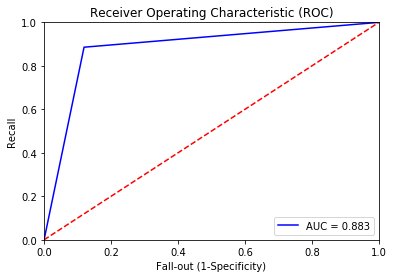

AUC score: 0.8831556503198295


In [28]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(Ytest, y_pred_binary)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#### Print Confusion Matrix

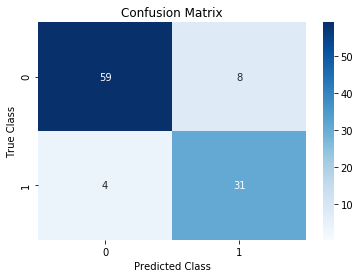

In [29]:
cm = confusion_matrix(Ytest, y_pred_binary)
labels = ['0', '1']
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.5);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

### Train model on entire data

In [30]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)
y_pred_full_lgb = 0

In [31]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain_full, Ytrain_full):
    counter += 1

    train_x, train_y = Xtrain_full[train], Ytrain_full[train]
    val_x, val_y = Xtrain_full[val], Ytrain_full[val]

    lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
    lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

    model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgvalidation], early_stopping_rounds=200, verbose_eval=1000)
    pred = model.predict(Xpredict, num_iteration=model.best_iteration)

    y_pred_full_lgb += pred

y_pred_full_lgb /= float(counter)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[201]	valid_0's multi_logloss: 0.28109
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[181]	valid_0's multi_logloss: 0.318151
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[167]	valid_0's multi_logloss: 0.326839
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[251]	valid_0's multi_logloss: 0.274252
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.329482


## XGBoost Model

### Build and train the model

In [32]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
y_pred_test_xgb = 0

In [ ]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain, Ytrain):
    counter += 1

    train_x, train_y = Xtrain[train], Ytrain[train]
    val_x, val_y = Xtrain[val], Ytrain[val]
    df = pd.DataFrame(train_y, columns=['class'])
    neg, pos = np.bincount(df['class'])
    
    model = XGBRegressor(
        objective='multi:softprob',
        eval_metric='mlogloss',
        booster='gbtree',
        sample_type='uniform',
        tree_method='hist',
        scale_pos_weight=neg/pos,
        grow_policy='lossguide',
        num_round=5000,
        num_class=2,
        max_bin=444,
        rate_drop=0.54,
        learning_rate=0.07,
        min_split_loss=0.41,
        max_depth=17,
        min_child_weight=10,
        subsample=0.634,
        colsample_bytree=0.923,
        reg_lambda=0.0004,
        max_leaves=99
    )

    model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=200, verbose=True)
    pred = model.predict(Xtest, ntree_limit=model.best_ntree_limit)

    y_pred_test_xgb += pred

y_pred_test_xgb /= float(counter)

[0]	validation_0-mlogloss:0.65036
Will train until validation_0-mlogloss hasn't improved in 200 rounds.
[1]	validation_0-mlogloss:0.61587
[2]	validation_0-mlogloss:0.58443
[3]	validation_0-mlogloss:0.55608
[4]	validation_0-mlogloss:0.53356
[5]	validation_0-mlogloss:0.51279
[6]	validation_0-mlogloss:0.49352
[7]	validation_0-mlogloss:0.47623
[8]	validation_0-mlogloss:0.45983
[9]	validation_0-mlogloss:0.44444
[10]	validation_0-mlogloss:0.43029
[11]	validation_0-mlogloss:0.41920
[12]	validation_0-mlogloss:0.40925
[13]	validation_0-mlogloss:0.39905
[14]	validation_0-mlogloss:0.39131
[15]	validation_0-mlogloss:0.38310
[16]	validation_0-mlogloss:0.37606
[17]	validation_0-mlogloss:0.37049
[18]	validation_0-mlogloss:0.36498
[19]	validation_0-mlogloss:0.35965
[20]	validation_0-mlogloss:0.35428
[21]	validation_0-mlogloss:0.35023
[22]	validation_0-mlogloss:0.34646
[23]	validation_0-mlogloss:0.34257
[24]	validation_0-mlogloss:0.33980
[25]	validation_0-mlogloss:0.33638
[26]	validation_0-mlogloss:0.3

[29]	validation_0-mlogloss:0.33823
[30]	validation_0-mlogloss:0.33557
[31]	validation_0-mlogloss:0.33303
[32]	validation_0-mlogloss:0.33169
[33]	validation_0-mlogloss:0.32905
[34]	validation_0-mlogloss:0.32839
[35]	validation_0-mlogloss:0.32638
[36]	validation_0-mlogloss:0.32333
[37]	validation_0-mlogloss:0.32107
[38]	validation_0-mlogloss:0.31982
[39]	validation_0-mlogloss:0.31980
[40]	validation_0-mlogloss:0.31973
[41]	validation_0-mlogloss:0.31894
[42]	validation_0-mlogloss:0.31765
[43]	validation_0-mlogloss:0.31650
[44]	validation_0-mlogloss:0.31544
[45]	validation_0-mlogloss:0.31433
[46]	validation_0-mlogloss:0.31381
[47]	validation_0-mlogloss:0.31317
[48]	validation_0-mlogloss:0.31160
[49]	validation_0-mlogloss:0.31078
[50]	validation_0-mlogloss:0.31110
[51]	validation_0-mlogloss:0.31205
[52]	validation_0-mlogloss:0.31164
[53]	validation_0-mlogloss:0.31140
[54]	validation_0-mlogloss:0.31005
[55]	validation_0-mlogloss:0.30928
[56]	validation_0-mlogloss:0.30828
[57]	validation_0-ml

### Validate the model

#### Print log_loss, accuracy and F1-score

In [ ]:
loss = log_loss(test_y, y_pred_test_xgb)
y_pred_binary = np.array([np.argmax(y_pred_test_xgb, axis=1)]).T
acc_score = accuracy_score(Ytest, y_pred_binary)
f1 = f1_score(Ytest, y_pred_binary)
print('Overall log_loss:', loss)
print('Overall accuracy:', acc_score)
print('Overall F1-Score:', f1)

#### Print Area Under Curve

In [ ]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(Ytest, y_pred_binary)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#### Print Confusion Matrix

In [ ]:
cm = confusion_matrix(Ytest, y_pred_binary)
labels = ['0', '1']
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.5);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

### Train model on entire data

In [ ]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
y_pred_full_xgb = 0

In [ ]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain_full, Ytrain_full):
    counter += 1

    train_x, train_y = Xtrain_full[train], Ytrain_full[train]
    val_x, val_y = Xtrain_full[val], Ytrain_full[val]
    df = pd.DataFrame(train_y, columns=['class'])
    neg, pos = np.bincount(df['class'])
    
    model = XGBRegressor(
        objective='multi:softprob',
        eval_metric='mlogloss',
        booster='gbtree',
        sample_type='uniform',
        tree_method='hist',
        scale_pos_weight=neg/pos,
        grow_policy='lossguide',
        num_round=5000,
        num_class=2,
        max_bin=444,
        rate_drop=0.54,
        learning_rate=0.07,
        min_split_loss=0.41,
        max_depth=17,
        min_child_weight=10,
        subsample=0.634,
        colsample_bytree=0.923,
        reg_lambda=0.0004,
        max_leaves=99
    )

    model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=200, verbose=True)
    pred = model.predict(Xpredict, ntree_limit=model.best_ntree_limit)

    y_pred_full_xgb += pred

y_pred_full_xgb /= float(counter)

## Validate cumulative predictions from both models

In [ ]:
y_pred_test = (y_pred_test_lgb + y_pred_test_xgb)/2

#### Print log_loss, accuracy and F1-score

In [ ]:
loss = log_loss(test_y, y_pred_test)
y_pred_binary = np.array([np.argmax(y_pred_test, axis=1)]).T
acc_score = accuracy_score(Ytest, y_pred_binary)
f1 = f1_score(Ytest, y_pred_binary)
print('Overall log_loss:', loss)
print('Overall accuracy:', acc_score)
print('Overall F1-Score:', f1)

#### Print Area Under Curve

In [ ]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(Ytest, y_pred_binary)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#### Print Confusion Matrix

In [ ]:
cm = confusion_matrix(Ytest, y_pred_binary)
labels = ['0', '1']
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.5);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

## Combine predictions from both models

In [ ]:
y_pred = (y_pred_full_lgb + y_pred_full_xgb)/2

## Create submission file

In [ ]:
submit_df = pd.DataFrame(y_pred, columns=['1','2'])
submit_df.head()

In [ ]:
submit_df.to_excel("Predictions/predictions_v11.xlsx", index=False)